In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [3]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [5]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv', header=False, index=False)

In [9]:
train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm.csv",30)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm.csv",30)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm.csv",30)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 30: 0
torch.Size([142397, 30]) torch.Size([142397])
length > 30: 0
torch.Size([35600, 30]) torch.Size([35600])
length > 30: 0
torch.Size([44499, 30]) torch.Size([44499])


# 2. train

In [10]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

In [12]:
device = torch.device("cuda",0)

In [15]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 169.97503, loss1: 1.72843, loss2_3: 168.24660
	train_acc: 0.6984, test_acc: 0.6960393258426967, time: 50.67
best_acc: 0.6960393258426967
epoch: 2, loss: 115.41453, loss1: 0.91515, loss2_3: 114.49937
	train_acc: 0.8114, test_acc: 0.8103651685393258, time: 50.38
best_acc: 0.8103651685393258
epoch: 3, loss: 102.23526, loss1: 0.85648, loss2_3: 101.37878
	train_acc: 0.8174, test_acc: 0.8175, time: 50.53
best_acc: 0.8175
epoch: 4, loss: 97.55190, loss1: 0.81617, loss2_3: 96.73573
	train_acc: 0.8449, test_acc: 0.8452808988764045, time: 50.48
best_acc: 0.8452808988764045
epoch: 5, loss: 93.61148, loss1: 0.78654, loss2_3: 92.82495
	train_acc: 0.8371, test_acc: 0.8367415730337079, time: 51.03
epoch: 6, loss: 92.52162, loss1: 0.77732, loss2_3: 91.74429
	train_acc: 0.8298, test_acc: 0.829129213483146, time: 50.76
epoch: 7, loss: 90.64412, loss1: 0.75739, loss2_3: 89.88674
	train_acc: 0.8502, test_acc: 0.8513483146067415, time: 50.59
best_acc: 0.8513483146067415
epoch: 8, loss: 89.4

epoch: 59, loss: 77.95799, loss1: 0.62634, loss2_3: 77.33166
	train_acc: 0.8746, test_acc: 0.8707022471910112, time: 47.39
epoch: 60, loss: 77.77385, loss1: 0.61951, loss2_3: 77.15435
	train_acc: 0.8734, test_acc: 0.8691011235955056, time: 47.44
epoch: 61, loss: 77.81653, loss1: 0.62228, loss2_3: 77.19425
	train_acc: 0.8739, test_acc: 0.8723876404494382, time: 47.73
best_acc: 0.8723876404494382
epoch: 62, loss: 77.81676, loss1: 0.62235, loss2_3: 77.19441
	train_acc: 0.8750, test_acc: 0.8712078651685393, time: 48.19
epoch: 63, loss: 77.58611, loss1: 0.62343, loss2_3: 76.96267
	train_acc: 0.8753, test_acc: 0.871938202247191, time: 47.54
epoch: 64, loss: 77.57607, loss1: 0.62113, loss2_3: 76.95494
	train_acc: 0.8757, test_acc: 0.8713483146067416, time: 48.36
epoch: 65, loss: 77.37984, loss1: 0.62070, loss2_3: 76.75914
	train_acc: 0.8737, test_acc: 0.8702808988764045, time: 47.41
epoch: 66, loss: 77.33127, loss1: 0.62108, loss2_3: 76.71019
	train_acc: 0.8748, test_acc: 0.8702808988764045, 

epoch: 120, loss: 73.96951, loss1: 0.59505, loss2_3: 73.37446
	train_acc: 0.8812, test_acc: 0.8710955056179776, time: 48.36
epoch: 121, loss: 73.83865, loss1: 0.59547, loss2_3: 73.24317
	train_acc: 0.8832, test_acc: 0.8732865168539325, time: 47.36
epoch: 122, loss: 73.71773, loss1: 0.59175, loss2_3: 73.12597
	train_acc: 0.8823, test_acc: 0.8720786516853932, time: 47.94
epoch: 123, loss: 73.66012, loss1: 0.59473, loss2_3: 73.06538
	train_acc: 0.8837, test_acc: 0.873314606741573, time: 48.09
epoch: 124, loss: 73.73861, loss1: 0.59302, loss2_3: 73.14558
	train_acc: 0.8837, test_acc: 0.8736516853932584, time: 44.83
epoch: 125, loss: 73.59672, loss1: 0.59468, loss2_3: 73.00204
	train_acc: 0.8831, test_acc: 0.8728089887640449, time: 39.53
epoch: 126, loss: 73.58880, loss1: 0.59451, loss2_3: 72.99429
	train_acc: 0.8825, test_acc: 0.8719662921348315, time: 34.49
epoch: 127, loss: 73.51181, loss1: 0.59086, loss2_3: 72.92095
	train_acc: 0.8822, test_acc: 0.8729775280898876, time: 34.48
epoch: 12

epoch: 182, loss: 70.10354, loss1: 0.57247, loss2_3: 69.53107
	train_acc: 0.8935, test_acc: 0.8720505617977528, time: 34.74
epoch: 183, loss: 69.85791, loss1: 0.56840, loss2_3: 69.28951
	train_acc: 0.8930, test_acc: 0.8729775280898876, time: 34.60
epoch: 184, loss: 69.91896, loss1: 0.57257, loss2_3: 69.34638
	train_acc: 0.8889, test_acc: 0.8673876404494382, time: 34.41
epoch: 185, loss: 69.91865, loss1: 0.57192, loss2_3: 69.34673
	train_acc: 0.8935, test_acc: 0.871685393258427, time: 34.49
epoch: 186, loss: 69.86096, loss1: 0.57238, loss2_3: 69.28858
	train_acc: 0.8933, test_acc: 0.8701123595505618, time: 34.54
epoch: 187, loss: 69.70523, loss1: 0.57305, loss2_3: 69.13218
	train_acc: 0.8923, test_acc: 0.8686797752808989, time: 34.48
epoch: 188, loss: 69.46302, loss1: 0.56896, loss2_3: 68.89406
	train_acc: 0.8882, test_acc: 0.8666573033707865, time: 34.42
epoch: 189, loss: 69.62266, loss1: 0.57161, loss2_3: 69.05105
	train_acc: 0.8947, test_acc: 0.8717977528089887, time: 34.39
epoch: 19

epoch: 244, loss: 64.11658, loss1: 0.54010, loss2_3: 63.57648
	train_acc: 0.9032, test_acc: 0.8657865168539326, time: 34.38
epoch: 245, loss: 64.23264, loss1: 0.53951, loss2_3: 63.69312
	train_acc: 0.9038, test_acc: 0.8687359550561797, time: 34.41
epoch: 246, loss: 63.87667, loss1: 0.54117, loss2_3: 63.33550
	train_acc: 0.9075, test_acc: 0.862752808988764, time: 34.44
epoch: 247, loss: 63.96578, loss1: 0.53789, loss2_3: 63.42789
	train_acc: 0.8872, test_acc: 0.8489606741573034, time: 34.40
epoch: 248, loss: 63.67154, loss1: 0.53639, loss2_3: 63.13515
	train_acc: 0.9097, test_acc: 0.8654775280898876, time: 34.42
epoch: 249, loss: 63.67761, loss1: 0.53624, loss2_3: 63.14138
	train_acc: 0.8990, test_acc: 0.8617696629213483, time: 34.38
epoch: 250, loss: 63.73648, loss1: 0.53940, loss2_3: 63.19709
	train_acc: 0.9088, test_acc: 0.864747191011236, time: 34.41


# 3. test

In [31]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [59]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [87]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [113]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.832639900145621
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     33706
           1       0.82      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298



rf auc : 0.9064775173821029


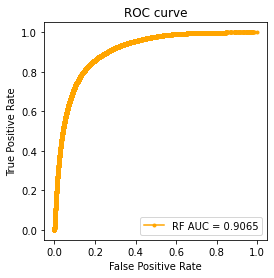

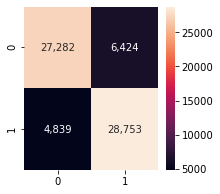

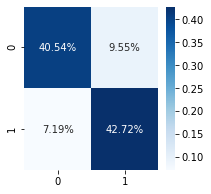

In [115]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()